In [1]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz

--2021-11-20 17:56:46--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.68.70
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.68.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  79.8MB/s    in 21s     

2021-11-20 17:57:07 (74.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [29]:
PATH_TO_WORD2VEC = "../../../research/uncertainty_benchmark/embeddings/GoogleNews-vectors-negative300.bin"

In [30]:
import cv2
import numpy as np
import pickle
import os
import itertools
import tqdm
import random
from PIL import Image

from text_preprocessing import Tokenizer, pad_sequences
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from gensim.utils import tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import models

import matplotlib.pyplot as plt

In [31]:
print("Torch version:", torch.__version__)

Torch version: 1.9.1


# Dataset Preprocessing

In [32]:
BASE_DIR = "dataset/"
DATASET_DIR = BASE_DIR + "text_data/"
IMAGES_DIR = BASE_DIR + "images/all_items/"

# Global Parameter Variables
MAX_SEQUENCE_LENGTH = 100
NUM_WORDS_TOKENIZER = 50000
EMBEDDING_DIM = 300
BATCH_SIZE = 32

In [33]:
def preprocess_img(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (256, 256))
  img = img.astype(np.float32) / 255
  return np.moveaxis(img, 2, 0)

def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)

In [35]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

room_to_items = {}

for item_url, room_url_list in item_to_rooms_map.items():
  item_id = item_url.split("/")[-1].split(".jpg")[0]
  if not os.path.exists(IMAGES_DIR + item_id + ".jpg"):
      print(item_url + " does not exist")
      continue

  for room_url in room_url_list:
    room_id = room_url.split("/")[-1].split(".jpg")[0]
    if room_id not in room_to_items:
      room_to_items[room_id] = [item_id]
    else:
      room_to_items[room_id].append(item_id)
    
with open(BASE_DIR + "train_sets_reweighted.pkl", "rb") as file:
    train_sets = pickle.load(file)
with open(BASE_DIR + "val_data_reweighted.pkl", "rb") as file:
    val_pairs, y_val = pickle.load(file)
with open(BASE_DIR + "preprocessed_text.pkl", "rb") as file:
    item_to_info = pickle.load(file)

images/890.333.75.jpg does not exist
images/991.333.98.jpg does not exist
images/990.612.97.jpg does not exist


In [36]:
class FurnitureImagePairsDataset(Dataset):
    """Dataset containing pairs of furniture items."""

    def __init__(self, image_path, pairs, labels):
        """
        Args:
            image_path (string): Path to the directory containing images.
            pairs (list of tuples of strings): Pairs of image IDs to be used as training samples.
            labels (array of integers): Labels for the training samples.
        """
        super(FurnitureImagePairsDataset, self).__init__()
        self.image_ids = list(set(x for pair in pairs for x in pair))
        self.index_mapping = {image_id: i for i, image_id in enumerate(self.image_ids)}
        self.images = [preprocess_img(image_path + image_id + ".jpg") for image_id in tqdm.tqdm(self.image_ids, ncols=80)]
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if isinstance(idx, (list, tuple)):
            x1, x2, y = zip(*[self[i] for i in idx])
            return torch.stack(x1), torch.stack(x2), torch.from_numpy(np.array(y))

        pair = self.pairs[idx]
        return self.images[self.index_mapping[pair[0]]], self.images[self.index_mapping[pair[1]]], self.labels[idx]

In [37]:
# For now, only use the first training set. We will try using PU bagging later.
train_pairs, y_train, train_scenes = train_sets[0]

In [38]:
X_train_image = FurnitureImagePairsDataset(IMAGES_DIR, train_pairs, y_train)
X_val_image = FurnitureImagePairsDataset(IMAGES_DIR, val_pairs, y_val)

100%|████████████████████████████████████████| 680/680 [00:02<00:00, 318.58it/s]


In [39]:
word2vecDict = KeyedVectors.load_word2vec_format(PATH_TO_WORD2VEC, binary=True)

def get_embedding_matrix(word_index):
    # One for zero, one for len(WORD_INDEX) which will be used as the EOT token
    embedding_matrix = np.random.randn(len(word_index)+2, EMBEDDING_DIM)
    embedding_matrix /= np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
    embeddedCount = 0
    for word, i in word_index.items():
        try:
            embedding_vector = word2vecDict[word]
        except KeyError:
            pass
        else:
            embedding_matrix[i] = embedding_vector
            embeddedCount += 1
    print("total embedded:", embeddedCount, "common words")
    return embedding_matrix

train_premise_texts = [item_to_info[id] for id, _ in train_pairs]
train_hypothesis_texts = [item_to_info[id] for _, id in train_pairs]
tokenizer = Tokenizer(num_words=NUM_WORDS_TOKENIZER, lower=True)
tokenizer.fit_on_texts(train_premise_texts + train_hypothesis_texts)
WORD_INDEX = tokenizer.word_index
print('Found %s unique tokens.' % len(WORD_INDEX))
print('Max len:', MAX_SEQUENCE_LENGTH)
WORD2VEC_EMBEDDING_MATRIX = get_embedding_matrix(WORD_INDEX)

X_train_text_premise = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(train_premise_texts)]
X_train_text_premise = pad_sequences(X_train_text_premise, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

X_train_text_hypothesis = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(train_hypothesis_texts)]
X_train_text_hypothesis = pad_sequences(X_train_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

Found 2005 unique tokens.
Max len: 100
total embedded: 1907 common words


In [23]:
train_premise_texts = [item_to_info[id] for id, _ in train_pairs]
train_hypothesis_texts = [item_to_info[id] for _, id in train_pairs]
tokenizer = Tokenizer(num_words=NUM_WORDS_TOKENIZER, lower=True)
tokenizer.fit_on_texts(train_premise_texts + train_hypothesis_texts)

with open("text_preprocessing_info.pkl", "rb") as file:
    WORD_INDEX, WORD2VEC_EMBEDDING_MATRIX = pickle.load(file)
    assert WORD_INDEX == tokenizer.word_index

print('Found %s unique tokens.' % len(WORD_INDEX))
print('Max len:', MAX_SEQUENCE_LENGTH)

X_train_text_premise = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(train_premise_texts)]
X_train_text_premise = pad_sequences(X_train_text_premise, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

X_train_text_hypothesis = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(train_hypothesis_texts)]
X_train_text_hypothesis = pad_sequences(X_train_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

Found 2030 unique tokens.
Max len: 100


In [43]:
from sklearn.metrics.pairwise import cosine_distances

dists = cosine_distances(WORD2VEC_EMBEDDING_MATRIX[len(WORD_INDEX) + 1].reshape(1, -1), WORD2VEC_EMBEDDING_MATRIX)
order = list(np.argsort(dists.flatten()))[:20]
for i in order:
    if i == 0 or i == len(WORD_INDEX) + 1: continue
    print(next(q for q, v in WORD_INDEX.items() if v == i), dists[0,i])

sturdy 0.8149443975259862
spotlight 0.8245677671757662
hanger 0.8266930090496071
handle 0.8275974711361982
parasol 0.8400551754885448
gloves 0.8456371886085474
rails 0.8471594789895696
lightweight 0.8498842882236268
damper 0.8521505624686629
hats 0.8587346957793748
folding 0.8599620042150518
pen 0.8599860418049521
rack 0.8604138898429275
rail 0.8621476551883281
quilted 0.862658341265573
suitable 0.8635136501430496
off 0.8644095949152492
slot 0.8652965613300614
secure 0.8653805415889626


In [23]:
val_premise_texts = [item_to_info[id] for id, _ in val_pairs]
val_hypothesis_texts = [item_to_info[id] for _, id in val_pairs]

# Please notice that: tokenizer is ONLY used on training set to build vocab
X_val_text_premise = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(val_premise_texts)]
X_val_text_premise = pad_sequences(X_val_text_premise, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

X_val_text_hypothesis = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(val_hypothesis_texts)]
X_val_text_hypothesis = pad_sequences(X_val_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [45]:
with open("text_preprocessing_info_reweighted.pkl", "wb") as file:
    pickle.dump((WORD_INDEX, WORD2VEC_EMBEDDING_MATRIX), file)

In [24]:
BATCH_SIZE = 32

img_train_data = X_train_image
text_train_data = TensorDataset(torch.from_numpy(X_train_text_premise),
                                torch.from_numpy(X_train_text_hypothesis),
                                torch.from_numpy(y_train))

img_val_data = X_val_image
text_val_data = TensorDataset(torch.from_numpy(X_val_text_premise),
                              torch.from_numpy(X_val_text_hypothesis), 
                              torch.from_numpy(y_val))

text_train_loader = DataLoader(text_train_data, batch_size=BATCH_SIZE)
img_train_loader = DataLoader(img_train_data, batch_size=BATCH_SIZE)

text_val_loader = DataLoader(text_val_data, batch_size=BATCH_SIZE)
img_val_loader = DataLoader(img_val_data, batch_size=BATCH_SIZE)

print(len(text_train_loader), len(img_train_loader))
print(len(text_val_loader), len(img_val_loader))

919 919
218 218


In [27]:
# Also load a dataset of individual products to get embeddings

val_product_ids = sorted(list(set(x for pair in train_pairs + val_pairs for x in pair)))
single_images = torch.stack([torch.from_numpy(preprocess_img(IMAGES_DIR + image_id + ".jpg"))
                             for image_id in tqdm.tqdm(val_product_ids)])

single_texts = [item_to_info[id] for id in val_product_ids]

# Please notice that: tokenizer is ONLY used on training set to build vocab
single_texts = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(single_texts)]
single_texts = torch.from_numpy(pad_sequences(single_texts, maxlen=MAX_SEQUENCE_LENGTH, padding='post'))

single_data = TensorDataset(single_images, single_texts)
single_loader = DataLoader(single_data, batch_size=BATCH_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2158/2158 [00:06<00:00, 337.58it/s]


# Model Specification

In [18]:
VGG_RELU_LAYERS = [3, 8, 15, 22, 29]
VGG_RELU_LAYER_SIZES = [64, 128, 256, 512, 512]

In [19]:
# class IntermediateFusionModel(nn.Module):
#     def __init__(self, vocab_size, embedding_matrix, stats_layer_idxs, stats_dims, output_dim, pre_fusion_layers=0):
#         super(IntermediateFusionModel, self).__init__()
#         self.vocab_size = vocab_size
#         num_embeddings, embedding_dim = embedding_matrix.shape[0], embedding_matrix.shape[1]
#         self.embedding_dim = embedding_dim
#         self.pre_fusion_layers = pre_fusion_layers

#         self.vgg_model = models.vgg16(pretrained=True)
#         self.image_encoder = self.vgg_model._modules.get("features")
#         # self.image_projection = nn.Parameter(torch.empty(4096, 128))
        
#         # self.final_img_fc = nn.Linear(25088, 128)
#         # self.final_img_dropout = nn.Dropout(0.5)
        
#         self.stats_layer_idxs = stats_layer_idxs
#         self.stats_dims = stats_dims
#         self.image_fcs = nn.ModuleList()
#         self.image_dropouts = nn.ModuleList()
#         # self.image_projections = nn.ParameterList()
#         for dim in self.stats_dims:
#             self.image_fcs.append(nn.Linear(dim * 2, embedding_dim))
#             self.image_dropouts.append(nn.Dropout(0.5))
#             # self.image_projections.append(nn.Parameter(torch.empty(dim * 2, 128 // len(self.stats_dims))))

#         self.text_emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
#         self.text_emb.weight.data.copy_(torch.from_numpy(embedding_matrix))
#         self.text_emb.weight.requires_grad = True

#         self.attention_layers = nn.ModuleList()
#         self.attention_lns = nn.ModuleList()
#         for i in range(pre_fusion_layers + len(self.stats_dims)):
#             self.attention_layers.append(nn.MultiheadAttention(embedding_dim, 1))
#             self.attention_lns.append(nn.LayerNorm(embedding_dim))
#         self.text_projection = nn.Parameter(torch.empty(embedding_dim, 128))
        
#         # self.combined_projection = nn.Parameter(torch.empty(256, 128))

#         # self.output_fc = nn.Linear(256, output_dim)
#         self.initialize_parameters()
        
#     def initialize_parameters(self):
#         if self.text_projection is not None:
#             nn.init.normal_(self.text_projection, std=self.embedding_dim ** -0.5)
#         # for proj in self.image_projections:
#         #     nn.init.normal_(proj, std=proj.size(0) ** -0.5)
#         # nn.init.normal_(self.combined_projection, std=self.combined_projection.size(0) ** -0.5)

#     def encode(self, text_inp, img_inp):
#         # enc = self.image_encoder(img_inp)
#         # enc = self.avgpool(enc).flatten(1)
#         # fc_1 = self.image_fc1(enc)
#         # fc_1 = F.relu(fc_1)
#         # fc_1 = self.image_dropout1(fc_1)

#         enc_inp = img_inp
#         stats_outputs = [None for _ in self.stats_layer_idxs]
#         # img_outputs = [None for _ in self.stats_layer_idxs]
#         for i in range(len(self.image_encoder)): # max(self.stats_layer_idxs) + 1):
#             enc_inp = self.image_encoder[i](enc_inp)
#             if i in self.stats_layer_idxs:
#                 idx = self.stats_layer_idxs.index(i)
#                 stat_enc = enc_inp.flatten(2)
#                 stat_enc = torch.cat([stat_enc.mean(2), stat_enc.std(2)], 1).squeeze()
                
#                 # img_outputs[idx] = stat_enc @ self.image_projections[idx]
#                 stat_fc = self.image_fcs[idx](stat_enc)
#                 stat_fc = F.relu(stat_fc)
#                 stat_fc = self.image_dropouts[idx](stat_fc)
#                 stats_outputs[idx] = stat_fc
        
#         # avgpool = self.vgg_model._modules.get("avgpool")
#         # enc_inp = avgpool(enc_inp).flatten(1)
#         # classifier = self.vgg_model._modules.get("classifier")
#         # for i in range(6):
#         #     enc_inp = classifier[i](enc_inp)
#         # img_fc = enc_inp @ self.image_projection
        
#         # img_fc = self.final_img_fc(enc_inp)
#         # img_fc = F.relu(img_fc)
#         # img_fc = self.final_img_dropout(img_fc)

#         text_enc = self.text_emb(text_inp).transpose(0, 1)
#         # text_enc shape: (seq length, batch size, embedding dim)
#         # We will add one value to the sequence (first axis) at each layer, 
#         # representing the instance norm statistics from VGG
    
#         for attn, lnorm in zip(self.attention_layers[:self.pre_fusion_layers], self.attention_lns[:self.pre_fusion_layers]):
#             text_enc, _ = attn(text_enc, text_enc, text_enc)
#             text_enc = lnorm(text_enc.transpose(0, 1)).transpose(0, 1)
            
#         for stats, attn, lnorm in zip(stats_outputs, self.attention_layers[self.pre_fusion_layers:], self.attention_lns[self.pre_fusion_layers:]):
#             text_enc = torch.cat([stats.unsqueeze(0), text_enc], 0)
#             text_enc, _ = attn(text_enc, text_enc, text_enc)
#             text_enc = lnorm(text_enc.transpose(0, 1)).transpose(0, 1)
            
#         text_enc = text_enc.transpose(0, 1)
#         text_enc = text_enc[torch.arange(text_enc.size(0)), text_inp.argmax(dim=-1) + len(stats_outputs)] @ self.text_projection
                
#         return text_enc # torch.cat([*img_outputs, text_enc], 1) @ self.combined_projection

#     def forward(self, text_inp1, text_inp2, img_inp1, img_inp2):
#         emb_1 = self.encode(text_inp1, img_inp1)
#         emb_2 = self.encode(text_inp2, img_inp2)
#         output = (emb_1 * emb_2).sum(1) # self.output_fc(torch.cat([emb_1, emb_2], 1))
#         return output
        
class IntermediateFusionModel(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, stats_layer_idxs, stats_dims, output_dim, pre_fusion_layers=0):
        super(IntermediateFusionModel, self).__init__()
        self.vocab_size = vocab_size
        num_embeddings, embedding_dim = embedding_matrix.shape[0], embedding_matrix.shape[1]
        self.embedding_dim = embedding_dim
        self.pre_fusion_layers = pre_fusion_layers

        self.vgg_model = models.vgg16(pretrained=True)
        self.image_encoder = self.vgg_model._modules.get("features")
        # self.image_projection = nn.Parameter(torch.empty(4096, 128))
        
        # self.final_img_fc = nn.Linear(25088, 128)
        # self.final_img_dropout = nn.Dropout(0.5)
        
        self.stats_layer_idxs = stats_layer_idxs
        self.stats_dims = stats_dims
        # self.image_fcs = nn.ModuleList()
        # self.image_dropouts = nn.ModuleList()
        # self.image_projections = nn.ParameterList()
        # for dim in self.stats_dims:
            # self.image_fcs.append(nn.Linear(dim * 2, embedding_dim))
            # self.image_dropouts.append(nn.Dropout(0.5))
            # self.image_projections.append(nn.Parameter(torch.empty(dim * 2, 128 // len(self.stats_dims))))

        self.text_emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.text_emb.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.text_emb.weight.requires_grad = True

        self.attention_layers = nn.ModuleList()
        self.attention_lns = nn.ModuleList()
        for i in range(pre_fusion_layers + len(self.stats_dims)):
            self.attention_layers.append(nn.MultiheadAttention(embedding_dim, 1))
            self.attention_lns.append(nn.LayerNorm(embedding_dim))
        self.text_projection = nn.Parameter(torch.empty(embedding_dim, 128))
        
        # self.combined_projection = nn.Parameter(torch.empty(256, 128))

        # self.output_fc = nn.Linear(256, output_dim)
        self.initialize_parameters()
        
    def initialize_parameters(self):
        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.embedding_dim ** -0.5)
        # for proj in self.image_projections:
        #     nn.init.normal_(proj, std=proj.size(0) ** -0.5)
        # nn.init.normal_(self.combined_projection, std=self.combined_projection.size(0) ** -0.5)

    def encode(self, text_inp, img_inp):
        # enc = self.image_encoder(img_inp)
        # enc = self.avgpool(enc).flatten(1)
        # fc_1 = self.image_fc1(enc)
        # fc_1 = F.relu(fc_1)
        # fc_1 = self.image_dropout1(fc_1)

#         enc_inp = img_inp
        stats_outputs = [None for _ in self.stats_layer_idxs]
#         img_outputs = [None for _ in self.stats_layer_idxs]
#         for i in range(len(self.image_encoder)): # max(self.stats_layer_idxs) + 1):
#             enc_inp = self.image_encoder[i](enc_inp)
#             if i in self.stats_layer_idxs:
#                 idx = self.stats_layer_idxs.index(i)
#                 stat_enc = enc_inp.flatten(2)
#                 stat_enc = torch.cat([stat_enc.mean(2), stat_enc.std(2)], 1).squeeze()
                
#                 img_outputs[idx] = stat_enc @ self.image_projections[idx]
#                 stat_fc = self.image_fcs[idx](stat_enc)
#                 stat_fc = F.relu(stat_fc)
#                 stat_fc = self.image_dropouts[idx](stat_fc)
#                 stats_outputs[idx] = stat_fc
        
        # avgpool = self.vgg_model._modules.get("avgpool")
        # enc_inp = avgpool(enc_inp).flatten(1)
        # classifier = self.vgg_model._modules.get("classifier")
        # for i in range(6):
        #     enc_inp = classifier[i](enc_inp)
        # img_fc = enc_inp @ self.image_projection
        
        # img_fc = self.final_img_fc(enc_inp)
        # img_fc = F.relu(img_fc)
        # img_fc = self.final_img_dropout(img_fc)

        text_enc = self.text_emb(text_inp).transpose(0, 1)
        # text_enc shape: (seq length, batch size, embedding dim)
        # We will add one value to the sequence (first axis) at each layer, 
        # representing the instance norm statistics from VGG
    
        for attn, lnorm in zip(self.attention_layers[:self.pre_fusion_layers], self.attention_lns[:self.pre_fusion_layers]):
            text_enc, _ = attn(text_enc, text_enc, text_enc)
            text_enc = lnorm(text_enc.transpose(0, 1)).transpose(0, 1)
            
        # for stats, attn, lnorm in zip(stats_outputs, self.attention_layers[self.pre_fusion_layers:], self.attention_lns[self.pre_fusion_layers:]):
        #     text_enc = torch.cat([stats.unsqueeze(0), text_enc], 0)
        #     text_enc, _ = attn(text_enc, text_enc, text_enc)
        #     text_enc = lnorm(text_enc.transpose(0, 1)).transpose(0, 1)
            
        text_enc = text_enc.transpose(0, 1)
        text_enc = text_enc[torch.arange(text_enc.size(0)), text_inp.argmax(dim=-1) + len(stats_outputs)] @ self.text_projection
                
        return text_enc # torch.cat([*img_outputs, text_enc], 1) @ self.combined_projection

    def forward(self, text_inp1, text_inp2, img_inp1, img_inp2):
        emb_1 = self.encode(text_inp1, img_inp1)
        emb_2 = self.encode(text_inp2, img_inp2)
        output = (emb_1 * emb_2).sum(1) # self.output_fc(torch.cat([emb_1, emb_2], 1))
        return output
        

In [20]:
# Tweak input parameters to model constructor here - they will be used in training loops below
def make_model():
#     return IntermediateFusionModel(len(WORD_INDEX)+1,
#                                    WORD2VEC_EMBEDDING_MATRIX,
#                                    [VGG_RELU_LAYERS[0], VGG_RELU_LAYERS[2]],
#                                    [VGG_RELU_LAYER_SIZES[0], VGG_RELU_LAYER_SIZES[2]],
#                                    1,
#                                    pre_fusion_layers=0)
    return IntermediateFusionModel(len(WORD_INDEX)+1, WORD2VEC_EMBEDDING_MATRIX,
                                [], # [VGG_RELU_LAYERS[0], VGG_RELU_LAYERS[2]],
                                [], # [VGG_RELU_LAYER_SIZES[0], VGG_RELU_LAYER_SIZES[2]],
                                1, pre_fusion_layers=2)

In [21]:
# Model Hyperparameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
MAIN_LEARNING_RATE = 1e-5
FINE_TUNE_LEARNING_RATE = 1e-7
EPOCHS = 20
CLIP = 5

import gc
gc.collect()
torch.cuda.empty_cache()

cpu


In [25]:
def train_model(model, criterion, optimizer, text_train_loader, img_train_loader):
    """Train model for one epoch and return accuracy and loss on training set"""
    model.train()
    total_acc_train = 0
    total_loss_train = 0
    
    for lstm, cnn in tqdm.tqdm(zip(text_train_loader, img_train_loader),
                               total=len(text_train_loader),
                               ncols=80):
        lstm_inp1, lstm_inp2, lstm_labels = lstm
        cnn_inp1, cnn_inp2, cnn_labels = cnn
        lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.long().to(DEVICE), lstm_inp2.long().to(DEVICE), lstm_labels.to(DEVICE)
        cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_labels.to(DEVICE)
        model.zero_grad()
        output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
        loss = criterion(output.squeeze(), lstm_labels.float())
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        with torch.no_grad():
            acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_train += acc
            total_loss_train += loss.item()
  
    return total_acc_train / len(text_train_loader), total_loss_train / len(text_train_loader)

def eval_model_pairs(model, criterion, optimizer, text_val_loader, img_val_loader):
    """Return accuracy and loss on a validation set"""
    model.eval()
    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():
        for lstm, cnn in tqdm.tqdm(zip(text_val_loader, img_val_loader),
                                   total=len(text_val_loader),
                                   ncols=80):
            lstm_inp1, lstm_inp2, lstm_labels = lstm
            cnn_inp1, cnn_inp2, cnn_labels = cnn
            lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.long().to(DEVICE), lstm_inp2.long().to(DEVICE), lstm_labels.to(DEVICE)
            cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_labels.to(DEVICE)
            model.zero_grad()
            output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
            val_loss = criterion(output.squeeze(), lstm_labels.float())
            acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_val += acc
            total_loss_val += val_loss.item()
    return total_acc_val / len(text_val_loader), total_loss_val / len(text_val_loader)

def eval_model_single(model, single_loader):
    """Returns embeddings for each product in the single product loader."""
    model.eval()
    embs = []
    with torch.no_grad():
        for image_inp, text_inp in tqdm.tqdm(single_loader,
                                             total=len(single_loader),
                                             ncols=80):
            image_inp = image_inp.to(DEVICE)
            text_inp = text_inp.long().to(DEVICE)
            embs.append(model.encode(text_inp, image_inp).cpu().numpy())
    return np.concatenate(embs, axis=0)

# Single Training Loop

In [ ]:
print("Currently using device: {}\n".format(DEVICE))

model = make_model()
# state = torch.load("checkpoint_intermediate_fusion.p", map_location=torch.device('cpu'))
# model.load_state_dict(state)

for param in model.vgg_model.parameters():
    param.requires_grad = False
# for param in model.image_encoder.parameters():
#     param.requires_grad = True
model.to(DEVICE)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(model.parameters(), lr=MAIN_LEARNING_RATE, weight_decay=1e-5)

print("Training Started...")
last_loss = 1e9
for i in range(EPOCHS):

    train_acc, train_loss = train_model(model, criterion, optimizer, text_train_loader, img_train_loader)
    val_acc, val_loss = eval_model_pairs(model, criterion, optimizer, text_val_loader, img_val_loader)
    
    print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    torch.cuda.empty_cache()
    if val_loss < last_loss:
        torch.save(model.state_dict(), "checkpoint_fine_tune.p")
    else:
        print("Loss increased - early stopping.")
        break
    last_loss = val_loss
    
embs = eval_model_single(model, single_loader)

with open("embeddings_fine_tune_{}.p".format(model_number), "wb") as file:
    pickle.dump((val_product_ids, embs), file)

In [28]:
model = make_model()
state = torch.load("intermediate_fusion_controls/checkpoint_text_only.p", map_location=torch.device('cpu'))
model.load_state_dict(state)

embs = eval_model_single(model, single_loader)

with open("intermediate_fusion_controls/embeddings_text_only.p", "wb") as file:
    pickle.dump((val_product_ids, embs), file)

100%|███████████████████████████████████████████| 68/68 [00:07<00:00,  9.27it/s]


# PU Bagging Training Loop

In [34]:
# Create tokenizer for text processing based on the first training set
train_premise_texts = [item_to_info[id] for id, _ in train_sets[0][0]]
train_hypothesis_texts = [item_to_info[id] for _, id in train_sets[0][0]]
tokenizer = Tokenizer(num_words=NUM_WORDS_TOKENIZER, lower=True)
tokenizer.fit_on_texts(train_premise_texts + train_hypothesis_texts)

with open("text_preprocessing_info.pkl", "rb") as file:
    WORD_INDEX, WORD2VEC_EMBEDDING_MATRIX = pickle.load(file)
    assert WORD_INDEX == tokenizer.word_index

print('Found %s unique tokens.' % len(WORD_INDEX))
print('Max len:', MAX_SEQUENCE_LENGTH)

Found 2030 unique tokens.
Max len: 100


In [35]:
# Initialize validation data - same as above

X_val_image = FurnitureImagePairsDataset(IMAGES_DIR, val_pairs, y_val)

val_premise_texts = [item_to_info[id] for id, _ in val_pairs]
val_hypothesis_texts = [item_to_info[id] for _, id in val_pairs]

# Please notice that: tokenizer is ONLY used on training set to build vocab
X_val_text_premise = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(val_premise_texts)]
X_val_text_premise = pad_sequences(X_val_text_premise, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

X_val_text_hypothesis = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(val_hypothesis_texts)]
X_val_text_hypothesis = pad_sequences(X_val_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

img_val_data = X_val_image
text_val_data = TensorDataset(torch.from_numpy(X_val_text_premise),
                              torch.from_numpy(X_val_text_hypothesis), 
                              torch.from_numpy(y_val))

text_val_loader = DataLoader(text_val_data, batch_size=BATCH_SIZE)
img_val_loader = DataLoader(img_val_data, batch_size=BATCH_SIZE)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:02<00:00, 282.38it/s]


In [ ]:
def training_loop(model, lr, n_epochs, text_train_loader, img_train_loader, text_val_loader, img_val_loader):
    criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    last_loss = 1e9
    for i in range(n_epochs):
        train_acc, train_loss = train_model(model, criterion, optimizer, text_train_loader, img_train_loader)
        val_acc, val_loss = eval_model_pairs(model, criterion, optimizer, text_val_loader, img_val_loader)
        print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        
        gc.collect()
        torch.cuda.empty_cache()
        if val_loss > last_loss:
            print("Loss increased - early stopping.")
            break
        last_loss = val_loss

for train_set_num, (train_pairs, y_train, train_scenes) in enumerate(train_sets):
    print("TRAINING SET", train_set_num)
    # Empty caches
    gc.collect()
    torch.cuda.empty_cache()

    # Initialize image dataset
    img_train_data = FurnitureImagePairsDataset(IMAGES_DIR, train_pairs, y_train)
    
    # Initialize text dataset
    train_premise_texts = [item_to_info[id] for id, _ in train_pairs]
    train_hypothesis_texts = [item_to_info[id] for _, id in train_pairs]

    X_train_text_premise = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(train_premise_texts)]
    X_train_text_premise = pad_sequences(X_train_text_premise, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    X_train_text_hypothesis = [s + [len(WORD_INDEX) + 1] for s in tokenizer.texts_to_sequences(train_hypothesis_texts)]
    X_train_text_hypothesis = pad_sequences(X_train_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    
    text_train_data = TensorDataset(torch.from_numpy(X_train_text_premise),
                                    torch.from_numpy(X_train_text_hypothesis),
                                    torch.from_numpy(y_train))

    text_train_loader = DataLoader(text_train_data, batch_size=BATCH_SIZE)
    img_train_loader = DataLoader(img_train_data, batch_size=BATCH_SIZE)

    # Build model
    model = make_model()
    for param in model.vgg_model.parameters():
        param.requires_grad = False
    model.to(DEVICE)
    print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

    training_loop(model, MAIN_LEARNING_RATE, EPOCHS,
                  text_train_loader, img_train_loader,
                  text_val_loader, img_val_loader)
    for param in model.image_encoder.parameters():
        param.requires_grad = True
    print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
    training_loop(model, FINE_TUNE_LEARNING_RATE, EPOCHS,
                  text_train_loader, img_train_loader,
                  text_val_loader, img_val_loader)
    
    embs = eval_model_single(model, single_loader)
    with open("embeddings_{}.p".format(train_set_num), "wb") as file:
        pickle.dump((val_product_ids, embs), file)

TRAINING SET 0


100%|██████████████████████████████████████| 1454/1454 [00:04<00:00, 294.56it/s]


Trainable parameters: 1564200


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.22it/s]


Epoch 1: train_loss: 2.0953 train_acc: 0.5168 | val_loss: 0.7048 val_acc: 0.5391


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 2: train_loss: 0.6968 train_acc: 0.5397 | val_loss: 0.6911 val_acc: 0.5557


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 3: train_loss: 0.6789 train_acc: 0.5676 | val_loss: 0.6809 val_acc: 0.5735


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 4: train_loss: 0.6626 train_acc: 0.5953 | val_loss: 0.6727 val_acc: 0.5873


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 5: train_loss: 0.6468 train_acc: 0.6167 | val_loss: 0.6675 val_acc: 0.5999


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 6: train_loss: 0.6325 train_acc: 0.6365 | val_loss: 0.6609 val_acc: 0.6110


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 7: train_loss: 0.6182 train_acc: 0.6545 | val_loss: 0.6621 val_acc: 0.6168
Loss increased - early stopping.
Trainable parameters: 16278888


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.17it/s]


Epoch 1: train_loss: 0.5977 train_acc: 0.6774 | val_loss: 0.6534 val_acc: 0.6186


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.19it/s]


Epoch 2: train_loss: 0.5944 train_acc: 0.6799 | val_loss: 0.6534 val_acc: 0.6200


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 3: train_loss: 0.5939 train_acc: 0.6812 | val_loss: 0.6534 val_acc: 0.6204
Loss increased - early stopping.


100%|███████████████████████████████████████████| 68/68 [00:05<00:00, 12.77it/s]


TRAINING SET 1


100%|██████████████████████████████████████| 1454/1454 [00:05<00:00, 281.89it/s]


Trainable parameters: 1564200


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.22it/s]


Epoch 1: train_loss: 2.0403 train_acc: 0.5185 | val_loss: 0.6996 val_acc: 0.5341


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 2: train_loss: 0.6928 train_acc: 0.5379 | val_loss: 0.6914 val_acc: 0.5479


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.22it/s]


Epoch 3: train_loss: 0.6810 train_acc: 0.5624 | val_loss: 0.6865 val_acc: 0.5625


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 4: train_loss: 0.6671 train_acc: 0.5896 | val_loss: 0.6762 val_acc: 0.5860


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 5: train_loss: 0.6518 train_acc: 0.6135 | val_loss: 0.6743 val_acc: 0.5924


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 6: train_loss: 0.6364 train_acc: 0.6368 | val_loss: 0.6759 val_acc: 0.6013
Loss increased - early stopping.
Trainable parameters: 16278888


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 1: train_loss: 0.6155 train_acc: 0.6623 | val_loss: 0.6583 val_acc: 0.6100


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.19it/s]


Epoch 2: train_loss: 0.6132 train_acc: 0.6660 | val_loss: 0.6582 val_acc: 0.6106


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.17it/s]


Epoch 3: train_loss: 0.6124 train_acc: 0.6675 | val_loss: 0.6583 val_acc: 0.6111
Loss increased - early stopping.


100%|███████████████████████████████████████████| 68/68 [00:05<00:00, 12.79it/s]


TRAINING SET 2


100%|██████████████████████████████████████| 1454/1454 [00:05<00:00, 288.22it/s]


Trainable parameters: 1564200


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.22it/s]


Epoch 1: train_loss: 2.0637 train_acc: 0.5192 | val_loss: 0.7034 val_acc: 0.5203


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 2: train_loss: 0.6929 train_acc: 0.5368 | val_loss: 0.6931 val_acc: 0.5315


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 3: train_loss: 0.6805 train_acc: 0.5577 | val_loss: 0.6857 val_acc: 0.5474


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.22it/s]


Epoch 4: train_loss: 0.6655 train_acc: 0.5903 | val_loss: 0.6787 val_acc: 0.5643


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 5: train_loss: 0.6498 train_acc: 0.6165 | val_loss: 0.6751 val_acc: 0.5755


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 6: train_loss: 0.6346 train_acc: 0.6371 | val_loss: 0.6687 val_acc: 0.5873


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 7: train_loss: 0.6199 train_acc: 0.6556 | val_loss: 0.6680 val_acc: 0.5952


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 8: train_loss: 0.6091 train_acc: 0.6676 | val_loss: 0.6653 val_acc: 0.6028


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 9: train_loss: 0.5961 train_acc: 0.6799 | val_loss: 0.6656 val_acc: 0.6052
Loss increased - early stopping.
Trainable parameters: 16278888


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.18it/s]


Epoch 1: train_loss: 0.5758 train_acc: 0.7011 | val_loss: 0.6574 val_acc: 0.6135


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.19it/s]


Epoch 2: train_loss: 0.5734 train_acc: 0.7011 | val_loss: 0.6574 val_acc: 0.6134


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.17it/s]


Epoch 3: train_loss: 0.5717 train_acc: 0.7044 | val_loss: 0.6576 val_acc: 0.6138
Loss increased - early stopping.


100%|███████████████████████████████████████████| 68/68 [00:05<00:00, 12.80it/s]


TRAINING SET 3


100%|██████████████████████████████████████| 1454/1454 [00:04<00:00, 291.53it/s]


Trainable parameters: 1564200


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 1: train_loss: 2.2026 train_acc: 0.5249 | val_loss: 0.7044 val_acc: 0.5265


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 2: train_loss: 0.6936 train_acc: 0.5408 | val_loss: 0.6925 val_acc: 0.5364


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.22it/s]


Epoch 3: train_loss: 0.6801 train_acc: 0.5595 | val_loss: 0.6858 val_acc: 0.5582


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.22it/s]


Epoch 4: train_loss: 0.6656 train_acc: 0.5869 | val_loss: 0.6801 val_acc: 0.5783


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 5: train_loss: 0.6509 train_acc: 0.6108 | val_loss: 0.6773 val_acc: 0.5893


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 6: train_loss: 0.6363 train_acc: 0.6323 | val_loss: 0.6756 val_acc: 0.5994


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 7: train_loss: 0.6236 train_acc: 0.6473 | val_loss: 0.6724 val_acc: 0.6058


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.22it/s]


Epoch 8: train_loss: 0.6096 train_acc: 0.6647 | val_loss: 0.6751 val_acc: 0.6101
Loss increased - early stopping.
Trainable parameters: 16278888


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.20it/s]


Epoch 1: train_loss: 0.5913 train_acc: 0.6874 | val_loss: 0.6570 val_acc: 0.6193


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.19it/s]


Epoch 2: train_loss: 0.5859 train_acc: 0.6899 | val_loss: 0.6569 val_acc: 0.6204


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.21it/s]


Epoch 3: train_loss: 0.5864 train_acc: 0.6909 | val_loss: 0.6569 val_acc: 0.6216
Loss increased - early stopping.


100%|███████████████████████████████████████████| 68/68 [00:05<00:00, 12.83it/s]


TRAINING SET 4


100%|██████████████████████████████████████| 1454/1454 [00:05<00:00, 289.53it/s]


Trainable parameters: 1564200


100%|█████████████████████████████████████████| 218/218 [00:34<00:00,  6.24it/s]


Epoch 1: train_loss: 1.7823 train_acc: 0.5198 | val_loss: 0.7122 val_acc: 0.5136


100%|█████████████████████████████████████████| 218/218 [00:34<00:00,  6.24it/s]


Epoch 2: train_loss: 0.6933 train_acc: 0.5407 | val_loss: 0.7009 val_acc: 0.5225


100%|█████████████████████████████████████████| 218/218 [00:35<00:00,  6.23it/s]


Epoch 3: train_loss: 0.6800 train_acc: 0.5622 | val_loss: 0.6922 val_acc: 0.5401


 33%|█████████████▌                           | 303/919 [00:52<01:46,  5.80it/s]

# Baseline Classifier for Text

In [97]:
embs_1 = []
embs_2 = []
labels = []
with torch.no_grad():
    for lstm, cnn in tqdm.tqdm(zip(text_val_loader, img_val_loader), total=len(text_val_loader)):
        lstm_inp1, lstm_inp2, lstm_labels = lstm
        cnn_inp1, cnn_inp2, cnn_labels = cnn
        lstm_inp1, lstm_inp2 = lstm_inp1.long().to(DEVICE), lstm_inp2.long().to(DEVICE)
        cnn_inp1, cnn_inp2 = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE)
        model.zero_grad()
        emb_1 = model.encode(lstm_inp1, cnn_inp1).cpu()
        emb_2 = model.encode(lstm_inp2, cnn_inp2).cpu()
        # output = (emb_1 * emb_2).sum(1) / (torch.linalg.norm(emb_1, dim=1) * torch.linalg.norm(emb_2, dim=1))
        embs_1.append(emb_1)
        embs_2.append(emb_2)
        labels.append(lstm_labels)
        
embs_1 = torch.cat(embs_1).numpy()
embs_2 = torch.cat(embs_2).numpy()
labels = torch.cat(labels).numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [00:15<00:00, 13.94it/s]


In [99]:
np.linalg.norm(embs_1, axis=1).shape

(6950,)

In [106]:
embs_2.shape

(6950, 256)

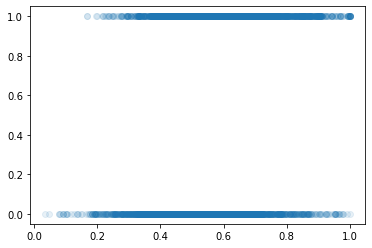

In [110]:
from sklearn.metrics.pairwise import cosine_similarity

plt.figure()
plt.scatter(torch.sigmoid((torch.from_numpy(embs_1) * torch.from_numpy(embs_2)).sum(1)).numpy(), labels, alpha=0.1)
# plt.scatter([cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)) for x, y in zip(embs_1, embs_2)], labels)
plt.show()